# Описание проекта
Я работаю в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения. В рамках проекта нужно исследовать воронку продаж и изучить результаты A/A/B-эксперимента.   
   
Мне предстоить изучить лог-файл с записями с действиями пользователей или событий:   
* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats as st
import seaborn as sns
import math as mth
import os

## Подготовка данных

In [2]:
pth1 = 'logs_exp.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, sep='\t')
else:
    print('Something is wrong')

In [3]:
display(df.head())
df.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
# переименуем столбцы
df.columns = ['event_name', 'user_id', 'event_time', 'group']

In [5]:
# время событий указано в формате unix. Переведём на привычный формат
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')
# и добавим столбец даты
df['event_dt'] = pd.to_datetime(df['event_time']).dt.date

In [6]:
# проверим явные и неявные дубликаты
print(f'Количество дубликатов в датасете: {df.duplicated().sum()}')
if df.duplicated().sum() > 0 :
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True, drop=True)
    print(f'Удаляем дубликаты, теперь их: {df.duplicated().sum()}')

Количество дубликатов в датасете: 413
Удаляем дубликаты, теперь их: 0


In [7]:
for columns in ['event_name', 'group'] :
    print(df[columns].unique())

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
[246 248 247]


In [8]:
display(df.head())
df.info()

,event_name,user_id,event_time,group,event_dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   event_dt    243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


Пропусков в данных нет, привели столбцы к нужному типу, добавили столбец с датой, удалили дубликаты. Можем идти дальше.

## Изучение и проверка данных

In [9]:
print(f'Всего событий в логе: {df.shape[0]}')
print(f'Всего пользователей: {len(df["user_id"].unique())}')

Всего событий в логе: 243713
Всего пользователей: 7551


In [10]:
print(f"В среднем событий приходится на пользователя: {round(df[['user_id', 'event_name']].groupby('user_id', as_index=False).count()['event_name'].mean(), 3)}")
print(f"Медианное количество событий на каждого пользователя: {df[['user_id', 'event_name']].groupby('user_id', as_index=False).count()['event_name'].median()}")

В среднем событий приходится на пользователя: 32.276
Медианное количество событий на каждого пользователя: 20.0


Также посмотрим на распределение количества событий по пользователям, построив гистограмму.

In [11]:
sns.set(rc={'figure.figsize':(12,8)})

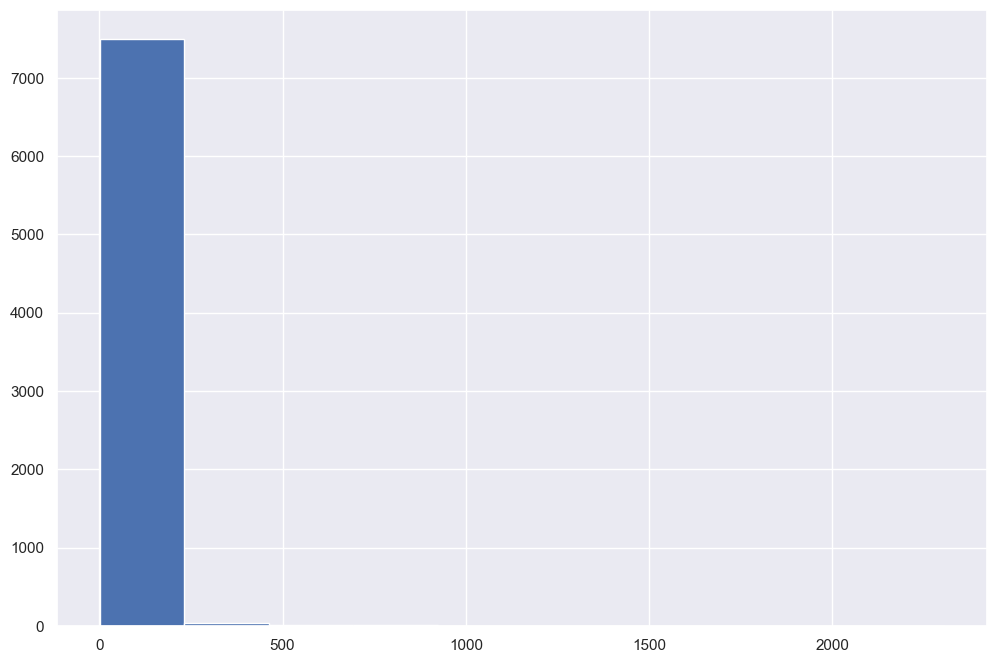

In [12]:
df[['user_id', 'event_name']].groupby('user_id', as_index=False).count()['event_name'].hist();

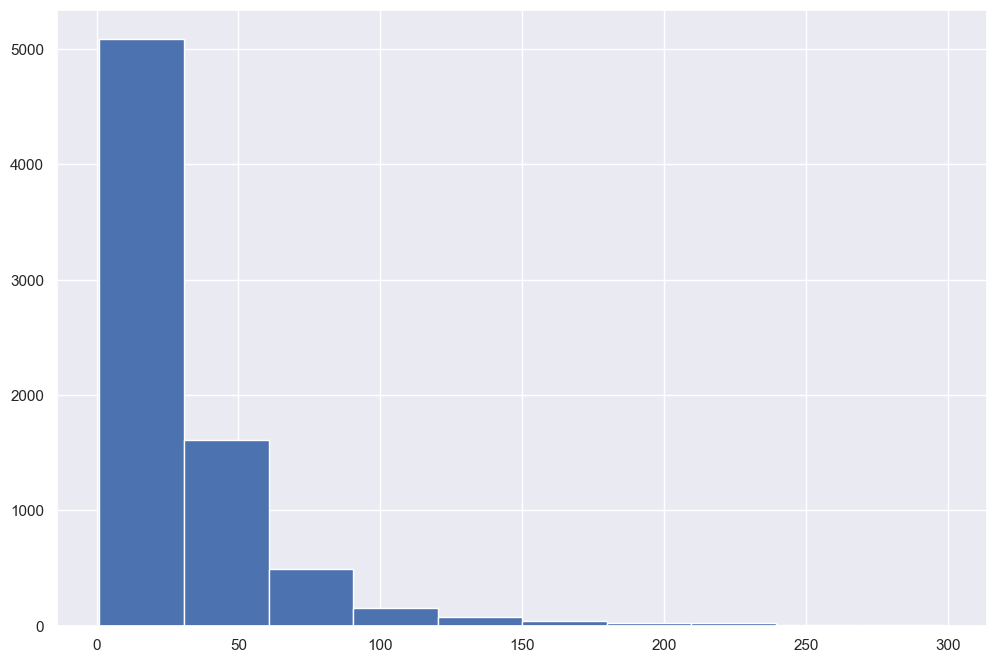

In [13]:
df[['user_id', 'event_name']].groupby('user_id', as_index=False).count().query("event_name < 300")['event_name'].hist();

In [14]:
# получим информацию о логе по дням 
print(f'Временной интервал лога в днях: {(pd.to_datetime(df["event_dt"]).max() - pd.to_datetime(df["event_dt"]).min()) + dt.timedelta(days=1)} ')
print(f'Количество дней в логе: {df["event_dt"].nunique()}')
print(f'Данные собраны за период {pd.to_datetime(df["event_dt"]).min().date()} - {pd.to_datetime(df["event_dt"]).max().date()}')

Временной интервал лога в днях: 14 days 00:00:00 
Количество дней в логе: 14
Данные собраны за период 2019-07-25 - 2019-08-07


In [15]:
# получим информацию о логе с учётом времени
print(f'Точный временной интервал лога: {df["event_time"].max() - df["event_time"].min()} ')
print(f'Данные собраны за временной период {df["event_time"].min()} - {df["event_time"].max()}')

Точный временной интервал лога: 13 days 16:31:41 
Данные собраны за временной период 2019-07-25 04:43:36 - 2019-08-07 21:15:17


Нужно убедиться, что у нас полноценные данные за каждый день периода.

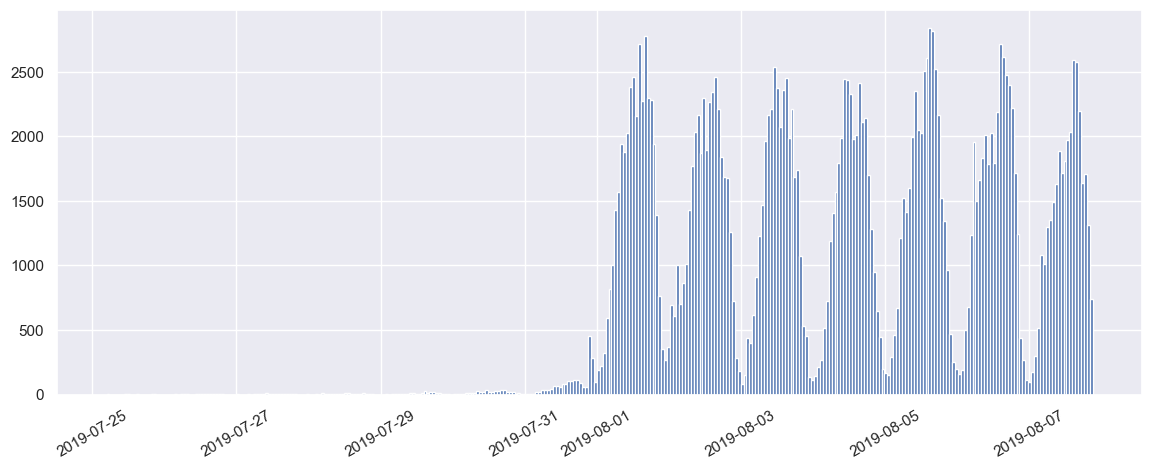

In [16]:
# код ревьюера
df['event_time'].hist(bins=14*24, figsize=(14, 5))
plt.xticks(rotation=30);

К сожалению, полноценные данные только с 01.08.2019. Для дальнейшего анализа оставим только эти данные.

In [17]:
# перед удалением посчитаем, сколько данных мы потеряем
print(f"Из датасета будет удалено {df.shape[0] - df[pd.to_datetime(df['event_dt']) >= '2019-08-01'].shape[0]} событий")
print(f"Из датасета будет удалено {round(abs(1 - df.shape[0] / df[pd.to_datetime(df['event_dt']) >= '2019-08-01'].shape[0]) * 100, 1)}% событий")

Из датасета будет удалено 2826 событий
Из датасета будет удалено 1.2% событий


In [18]:
print(f"Из датасета будут удалены {df['user_id'].drop_duplicates().shape[0] - df[pd.to_datetime(df['event_dt']) >= '2019-08-01']['user_id'].drop_duplicates().shape[0]} пользователей")
print(f"Из датасета будут удалены {round(abs(1 - df['user_id'].drop_duplicates().shape[0] / df[pd.to_datetime(df['event_dt']) >= '2019-08-01']['user_id'].drop_duplicates().shape[0]) * 100, 1)}% пользователей")

Из датасета будут удалены 17 пользователей
Из датасета будут удалены 0.2% пользователей


In [19]:
df = df[pd.to_datetime(df['event_dt']) >= '2019-08-01']

In [20]:
# проверим, что данные обновились
print(f'Точный временной интервал лога: {df["event_time"].max() - df["event_time"].min()} ')
print(f'Данные собраны за временной период {df["event_time"].min()} - {df["event_time"].max()}')

Точный временной интервал лога: 6 days 21:07:49 
Данные собраны за временной период 2019-08-01 00:07:28 - 2019-08-07 21:15:17


In [21]:
# Проверим, сколько у нас теперь событий и уникальных пользователей; не потеряли ли мы события или группы
print(f'Всего событий в логе: {df.shape[0]}')
print(f'Всего пользователей: {len(df["user_id"].unique())}')
print()
for columns in ['event_name', 'group'] :
    print(df[columns].unique())

Всего событий в логе: 240887
Всего пользователей: 7534

['Tutorial' 'MainScreenAppear' 'OffersScreenAppear' 'CartScreenAppear'
 'PaymentScreenSuccessful']
[246 247 248]


## Изучим воронку событий

Мы уже увидели следующие события в логе:   
* `Tutorial` - страница обучения;
* `MainScreenAppear` - переход на главный экран;
* `OffersScreenAppear` - экран предложения о покупке;
* `CartScreenAppear` - страница оплаты;
* `PaymentScreenSuccessful` - страница "успешной оплаты".

Составим и проверим воронку событий.

In [22]:
df["event_name"].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [23]:
# Определим воронку событий
df.sort_values(by='event_time')['event_name'].drop_duplicates()

2826                   Tutorial
2827           MainScreenAppear
2829         OffersScreenAppear
2844           CartScreenAppear
2845    PaymentScreenSuccessful
Name: event_name, dtype: object

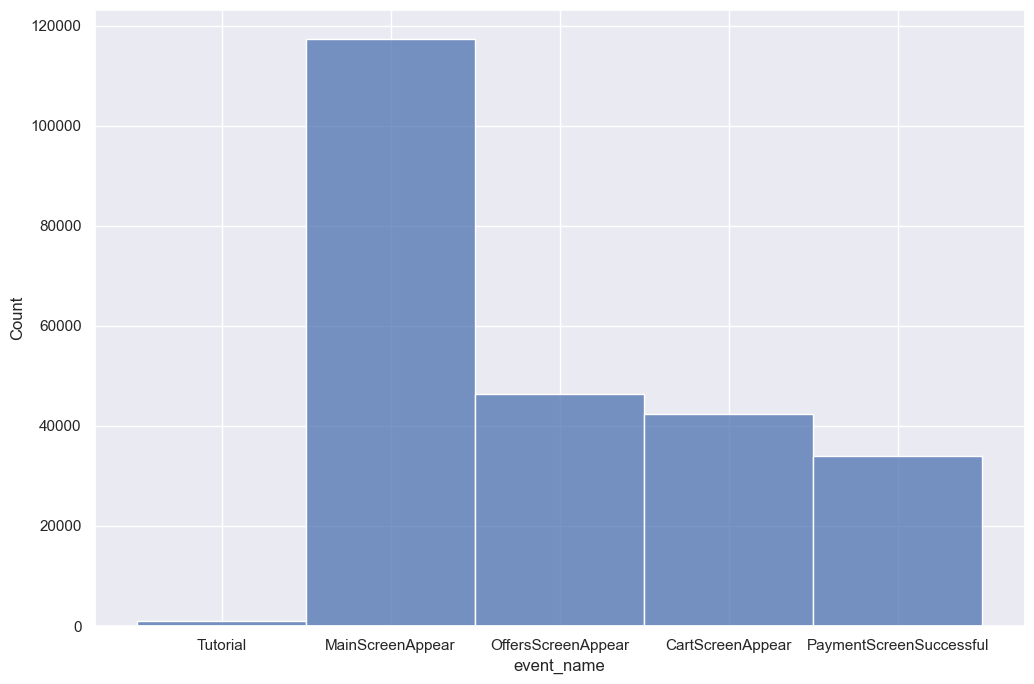

In [24]:
sns.histplot(data=df["event_name"], bins=df["event_name"].nunique());

Первым встречается событие "обучение", однако оно происходило реже всего. Скорее всего, у пользователей есть опция пропустить это обучение, а данных о таком событии нет.   
Если убрать событие "обучения", получается такая воронка:
* `MainScreenAppear` - переход на главный экран;
* `OffersScreenAppear` - экран предложения о покупке;
* `CartScreenAppear` - страница оплаты;
* `PaymentScreenSuccessful` - страница "успешной оплаты".   

In [25]:
# посчитаем количество уникальных пользователей для каждого события и долю пользователей для каждого события
event_grouped = df[['event_name','user_id']].groupby('event_name').nunique('user_id').sort_values(by='user_id', ascending=False)
event_grouped['event_conv'] = round(event_grouped['user_id'] / df['user_id'].nunique(), 3)
event_grouped

,user_id,event_conv
event_name,,
MainScreenAppear,7419,0.985
OffersScreenAppear,4593,0.610
CartScreenAppear,3734,0.496
PaymentScreenSuccessful,3539,0.470
Tutorial,840,0.111


Исключу событие "обучение". Добавлю ещё один столбец в сгруппированную таблицу - конверсия каждого этапа (доля пользователей, перешедших на события, с прошлого события) 

In [26]:
event_grouped = event_grouped.query('event_name != "Tutorial"')
event_grouped['event_conv_prev'] = round(event_grouped['user_id'] / event_grouped['user_id'].shift(), 3)
event_grouped

C:\Users\Рома\AppData\Local\Temp\ipykernel_4108\1820418455.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_grouped['event_conv_prev'] = round(event_grouped['user_id'] / event_grouped['user_id'].shift(), 3)


,user_id,event_conv,event_conv_prev
event_name,,,
MainScreenAppear,7419,0.985,NaN
OffersScreenAppear,4593,0.610,0.619
CartScreenAppear,3734,0.496,0.813
PaymentScreenSuccessful,3539,0.470,0.948


**Вывод:** больше всего пользователей теряется на шаге "главный экран" -> "экран предложения о покупке" - 40% пользователей теряется.   
Конверсия в покупку с запуска приложения равна 0,47. 

## Изучим результаты А/А/В эксперимента

Проверим количество пользователей.

In [27]:
# в целях дальнейшего анализа исключим событие "обучение", так как оно вне воронки
df = df[df['event_name'] != 'Tutorial']

In [28]:
# кол-во пользователей в каждой экспериментальной группе
df[['group', 'user_id']].groupby('group').nunique('user_id')

,user_id
group,
246,2483
247,2512
248,2535


Количество пользователей в каждой группе примерно одинаковое.

Проверим, нет ли пользователей, которые попали две или три группы.

In [29]:
print('количество пользователей, которые попали в группы 246 и 247: ', end='')
print(df.query('group == 246')['user_id'].drop_duplicates()\
          .isin(df.query('group == 247')['user_id'].drop_duplicates()).sum())
print('количество пользователей, которые попали в группы 247 и 248: ', end='')
print(df.query('group == 247')['user_id'].drop_duplicates()\
          .isin(df.query('group == 248')['user_id'].drop_duplicates()).sum())
print('количество пользователей, которые попали в группы 246 и 248: ', end='')
print(df.query('group == 246')['user_id'].drop_duplicates()\
          .isin(df.query('group == 248')['user_id'].drop_duplicates()).sum())

количество пользователей, которые попали в группы 246 и 247: 0
количество пользователей, которые попали в группы 247 и 248: 0
количество пользователей, которые попали в группы 246 и 248: 0


246 и 247 — контрольные группы, а 248 — экспериментальная. Между группами 246 и 247 не должно быть различий. Чтобы убедиться в этом, проверим, находят ли статистические критерии разницу между выборками 246 и 247.   
   
Проверим статистическую значимость различия конверсии пользователя в покупателя в контрольных группах. Сформулируем нулевую гипотезу:   
*"Конверсия пользователей в покупателей в контрольных группа одинаковая"*.

In [30]:
# сохраним датасет с контрольными группами
df_cnt = df[df['group'] != 248]

In [31]:
users_cnt = df_cnt[['group', 'user_id']].groupby('group').nunique('user_id')
users_cnt

,user_id
group,
246,2483
247,2512


In [32]:
buyers_cnt = df_cnt.query("event_name == 'PaymentScreenSuccessful'")[['user_id', 'group']].drop_duplicates()\
                                                            .groupby('group').count()
buyers_cnt

,user_id
group,
246,1200
247,1158


In [33]:
alpha_cnt = .05 # критический уровень статистической значимости

users_cnt = users_cnt.to_numpy()
buyers_cnt = buyers_cnt.to_numpy()
# пропорция успехов в группе 246:
p1_cnt = buyers_cnt[0]/users_cnt[0]

# пропорция успехов в группе 247:
p2_cnt = buyers_cnt[1]/users_cnt[1]

# пропорция успехов общая:
p_combined_cnt = (buyers_cnt[0] + buyers_cnt[1]) / (users_cnt[0] + users_cnt[1])

# разница пропорций
difference_cnt = p1_cnt - p2_cnt 
difference_cnt

array([0.02229909])

In [34]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value_cnt = difference_cnt / mth.sqrt(p_combined_cnt * (1 - p_combined_cnt) * (1/users_cnt[0] + 1/users_cnt[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value_cnt = (1 - distr.cdf(abs(z_value_cnt))) * 2

print('p-значение: ', p_value_cnt)

if p_value_cnt < alpha_cnt:
    print('Отвергаем нулевую гипотезу: между конверсиями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными'
    )

p-значение:  [0.11446628]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными


Продолжим анализ результатов эксперимента.   
Сделаем следующие шаги:  
1) Подготовим таблицу в разрезе трёх групп с кол-вом пользователей на каждом событии, доле пользователей события от общего кол-ва пользователей;
2) Проверим статистическую значимость различий доли пользователей, совершивших самое популярное событие `MainScreenAppear` в контрольных группах;
3) Повторим шаг 2, для оставшихся событий, также между контрольными группами;
4) Повторим шаги 2,3 уже с экспериментальной группой: множественное сравнение всех трёх групп по всем событиям;
5) Повторим шаги 2,3, но теперь объединим контрольные группы в одну.

In [35]:
df_group_info = df[['user_id', 'group']].drop_duplicates().groupby('group').count()
for event in df['event_name'].unique() :
    df_group_info[event] = df.query("event_name == @event")[['user_id', 'group']].drop_duplicates().groupby('group').count()
    # доля пользователей, совершивших это событие
    df_group_info[event+'_share'] = round(df_group_info[event] / df_group_info['user_id'], 3)
df_group_info

,user_id,MainScreenAppear,MainScreenAppear_share,OffersScreenAppear,OffersScreenAppear_share,CartScreenAppear,CartScreenAppear_share,PaymentScreenSuccessful,PaymentScreenSuccessful_share
group,,,,,,,,,
246,2483,2450,0.987,1542,0.621,1266,0.510,1200,0.483
247,2512,2476,0.986,1520,0.605,1238,0.493,1158,0.461
248,2535,2493,0.983,1531,0.604,1230,0.485,1181,0.466


In [36]:
# Нам предстоить сделать несколько статистическийх тестов, поэтому обернём его в функцию

def z_value_func(success, totals, alpha, event) :
    '''Функция о проверке гипотезы о равенстве долей. На вход получаем массив со значениями успешных пользователей
        и массив со значениями общего кол-ва пользователей и уровень альфа.
        Функция выводит p-value и решение о принятии/отклонении нулевой гипотезы'''
    #выведем вводные для эксперимента
    print(f"Нулевая гипотеза: конверсия в событие {event} у групп {success.reset_index().loc[0,'group']} и {success.reset_index().loc[1,'group']} равна")
    
    success = success.to_numpy()
    totals = totals.to_numpy()
    # пропорция успехов в группе 1:
    p1 = success[0]/totals[0]

    # пропорция успехов в группе 2:
    p2 = success[1]/totals[1]

    # пропорция успехов общая:
    p_combined = (success[0] + success[1]) / (totals[0] + totals[1])

    # разница пропорций
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/totals[0] + 1/totals[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(event)
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между конверсиями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными'
        )
    print('')

In [37]:
# Проверим статистическую значимость различий доли пользователей, совершивших самое популярное событие MainScreenAppear в контрольных группах
z_value_func(df_group_info['MainScreenAppear'], df_group_info['user_id'], 0.05, 'MainScreenAppear')

Нулевая гипотеза: конверсия в событие MainScreenAppear у групп 246 и 247 равна
MainScreenAppear
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными



Статистически значимых различий нет, теперь проделаем аналогичный анализ для оставшихся событий.

In [38]:
for event in df.query("event_name != 'MainScreenAppear'")['event_name'].unique() :
    z_value_func(df_group_info[event], df_group_info['user_id'], 0.05, event)

Нулевая гипотеза: конверсия в событие OffersScreenAppear у групп 246 и 247 равна
OffersScreenAppear
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Нулевая гипотеза: конверсия в событие CartScreenAppear у групп 246 и 247 равна
CartScreenAppear
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Нулевая гипотеза: конверсия в событие PaymentScreenSuccessful у групп 246 и 247 равна
PaymentScreenSuccessful
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными



Отлично, статистически значимых различий нет для всех событий. Продолжим анализ уже с экспериментальной группой. Так как мы проводим множественное сравнение, применим метод Шидака. Используем именно этот метод, ведь полезно увидеть даже небольшие изменения в поведении, так как мы всего лишь поменяли шрифт.

In [39]:
for event in df['event_name'].unique() :
    for group_cnt in [247,246] :
        df_group_info_filt = df_group_info.query("group != @group_cnt")
        z_value_func(df_group_info_filt[event], df_group_info_filt['user_id'], 1 - (1 - 0.05)**(1/2), event)

Нулевая гипотеза: конверсия в событие MainScreenAppear у групп 246 и 248 равна
MainScreenAppear
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Нулевая гипотеза: конверсия в событие MainScreenAppear у групп 247 и 248 равна
MainScreenAppear
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Нулевая гипотеза: конверсия в событие OffersScreenAppear у групп 246 и 248 равна
OffersScreenAppear
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Нулевая гипотеза: конверсия в событие OffersScreenAppear у групп 247 и 248 равна
OffersScreenAppear
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Нулевая гипотеза: конверсия в событие CartScreenAppear у групп 246 и 248 равна
CartScreenAppear
p-значение:  0.08067367598823139
Не получилось 

Анализ не показал статистически значимых различий экспериментальной группы с контрольными.   
Теперь попробуем объединить контрольные группы и повторить шаги.

In [40]:
df_2 = df.copy()
df_2['group'] = df_2['group'].replace([246,247], '"контрольная"')
df_2['group'] = df_2['group'].replace(248, '"экспериментальная"')
df_2['group'].unique()

array(['"контрольная"', '"экспериментальная"'], dtype=object)

In [41]:
df_group_info_2 = df_2[['user_id', 'group']].drop_duplicates().groupby('group').count()
for event in df_2['event_name'].unique() :
    df_group_info_2[event] = df_2.query("event_name == @event")[['user_id', 'group']].drop_duplicates().groupby('group').count()
    # доля пользователей, совершивших это событие
    df_group_info_2[event+'_share'] = round(df_group_info_2[event] / df_group_info_2['user_id'], 3)
df_group_info_2

,user_id,MainScreenAppear,MainScreenAppear_share,OffersScreenAppear,OffersScreenAppear_share,CartScreenAppear,CartScreenAppear_share,PaymentScreenSuccessful,PaymentScreenSuccessful_share
group,,,,,,,,,
"""контрольная""",4995,4926,0.986,3062,0.613,2504,0.501,2358,0.472
"""экспериментальная""",2535,2493,0.983,1531,0.604,1230,0.485,1181,0.466


In [42]:
for event in df['event_name'].unique() :
        z_value_func(df_group_info_2[event], df_group_info_2['user_id'], 0.05, event)

Нулевая гипотеза: конверсия в событие MainScreenAppear у групп "контрольная" и "экспериментальная" равна
MainScreenAppear
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Нулевая гипотеза: конверсия в событие OffersScreenAppear у групп "контрольная" и "экспериментальная" равна
OffersScreenAppear
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Нулевая гипотеза: конверсия в событие CartScreenAppear у групп "контрольная" и "экспериментальная" равна
CartScreenAppear
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Нулевая гипотеза: конверсия в событие PaymentScreenSuccessful у групп "контрольная" и "экспериментальная" равна
PaymentScreenSuccessful
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными



**Промежуточные выводы**: Я провел 12 статистических тестов с экспериментальной группой и 4 теста между контрольными группами. Для оценки статистической значимости взял уровень значимости 0.05. Уровень значимости показывает вероятность получения ложнопозитивного результата (ошибки первого рода) - найти статистические значимые различия там, где их на самом деле нет.

Проверка каждого события между двумя контрольными группами и экспериментальной предполагает проведение трёх сравнений. При уровне значимости 0.05 вероятность получить ошибку первого рода при анализе каждого события увеличивается и уже становится 0.1426 (по формуле: 1-(1-а)^3). Для уменьшения вероятности ошибки первого рода используют разные методы корректировки уровня значимости, например, методы Бонферрони, Холма, Шидака.   
Я использовал метод Шидака, так как он не так сильно уменьщает мощность теста, в отличии от метода Бонферрони.

Принимаю решение остановить тест. Признать его успешным.
Фиксируем результаты:
* А/А/В тест проведён корректно;
* Нет статистически значимого различия в поведении пользователей между группами ни по одному из событий.

## Финальный вывод

Мною была проведена аналитика поведения пользователей мобильного приложения по продаже продуктов питания. Данные содержали данные о событиях от перехода на главный экран до совершения покупки за период 01.08.2019 - 07.08.2019. За этот период произошло 240887 событий, сделанных 7534 пользователями. В среднем пользователь совершал 32 события.   
По итогам анализа воронки событий есть следующие выводы:
1) Конверсия в покупку с запуска приложения равна 47%;
2) больше всего пользователей "отваливается" на этапе `MainScreenAppear` -> `OffersScreenAppear`, около 62%;
3) 20% пользователей не перешли с события `OffersScreenAppear` на `CartScreenAppear`;
4) 5% пользователей не перешли с события `CartScreenAppear` на `PaymentScreenSuccessful`.   
   
Был проведён А/А/В тест, экспериментальной группе был показан изменённый шрифт в приложении. Параметры тестирования:
* даты: 1 августа 2019 - 7 августа 2019;
* количество посетителей: 7534, две контрольные группы: `246` - 2483 пользователя и `247` - 2512 пользователя, одна экспериментальная (`248`) - 2535.   
   
Анализ результатов теста показал, что нет статистически значимого различия в поведении пользователей между группами ни по одному из событий.